In [1]:
import os, glob
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
import matplotlib.dates as mdates

In [31]:
fs=16
plt.rc("font",size=fs)

In [50]:
from IPython.display import Image

In [2]:
figPath = "/glade/u/home/doubrawa/figs/"

In [3]:
inPath = "/glade/scratch/doubrawa/post_processing/"

In [4]:
fnames = sorted(glob.glob(os.path.join(inPath,"*SFC*.nc")))

In [5]:
fnames

['/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:00.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:10.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:20.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:30.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:40.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:50.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:00.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:10.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:20.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:30.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:40.nc',
 '/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:50.nc',
 '/glade/scratch/doubrawa/post_processin

In [6]:
varnames = ["HFX","QFX","LH","RMOL","UST","QVAPOR","theta","ALT"]

## some params

In [7]:
# how wide of a square box should we consider when averaging zi in space? [km]
extent_of_interest_km = 15
# spatial resolution of domain output in x/y [km]
dx_km = 0.025
# which grid points does that correspond to?
extent_of_interest_npts = int(np.round(extent_of_interest_km/dx_km))

In [8]:
extent_of_interest_npts

600

In [9]:
n_sn = 1200
n_we = 1200

In [10]:
sn_start = int((n_sn-extent_of_interest_npts)/2)
sn_end = int(sn_start+extent_of_interest_npts)

we_start = int((n_we-extent_of_interest_npts)/2)
we_end = int(we_start+extent_of_interest_npts)

# i/o

In [11]:
viz_full_domain = False
viz_subset      = False

In [12]:
obukhov_computed = {}
obukhov_model    = {}

In [13]:
i = 0

for fname in fnames:
    
    print(fname)
    
    #io    
    xr = xarray.open_dataset(fname)
    time_str = fname.split('_SFC_')[-1][0:-3]
    pd_time  = pd.to_datetime(time_str,format="%Y-%m-%d_%H:%M")    

    # over the entire domain
    cp          = 1004.5
    rho         = (1/xr.ALT)
    nominator   = - xr.UST**3 * xr.theta
    flux        = (xr.HFX + xr.LH) / (rho * cp)
    denominator = 0.4 * 9.81 * flux
    l           = nominator/denominator
    l_model     = 1/xr.RMOL
    
    # subset
    l_subset   = l.isel(south_north=np.arange(sn_start,sn_end,1)).isel(west_east=np.arange(we_start,we_end,1))
    l_model_subset = l_model.isel(west_east=np.arange(we_start,we_end,1)).isel(south_north=np.arange(sn_start,sn_end,1))
    we_subset = xr.west_east.isel(west_east=np.arange(we_start,we_end,1))    
    sn_subset = xr.south_north.isel(south_north=np.arange(sn_start,sn_end,1))
    
    # save
    obukhov_computed[pd_time] = float(l_subset.median().values)
    obukhov_model[pd_time] = float(l_model_subset.median().values)
    
    if viz_full_domain:
        fig = plt.figure(figsize=(15,7))

        ax1 = fig.add_subplot(121)
        
        ctr                = l_model.data
        ctr[np.isinf(ctr)] = np.nan
        
        p1 = ax1.pcolormesh(xr.west_east, xr.south_north, ctr,vmin=-200.,vmax=200)
        ax1.set_xlabel("west_east [pts]")
        ax1.set_ylabel("south_north [pts]") 
        ax1.set_title("1/RMOL from WRF-LES\n"+"median $\sim{0:.1f}$".format(np.nanmedian(ctr)))
        plt.colorbar(p1)

        ax2 = fig.add_subplot(122)
        
        ctr                = l.data
        ctr[np.isinf(ctr)] = np.nan    
        
        p2 = ax2.pcolormesh(xr.west_east, xr.south_north, ctr, vmin=-200.,vmax=200)
        ax2.set_xlabel("west_east [pts]")
        ax2.set_ylabel("south_north [pts]") 
        ax2.set_title("(-UST**3 * THETA)/( 0.4 * 9.81 * ((HFX+LH)*(1/ALT)*CP))\n"+"median $\sim{0:.1f}$".format(np.nanmedian(ctr)))
        plt.colorbar(p2)

        fig.savefig(os.path.join(figPath,"full_domain_{0}.png".format(time_str.replace(":","-"))),dpi=300,bbox_inches="tight")

    if viz_subset:
        fig = plt.figure(figsize=(15,7))

        ax1 = fig.add_subplot(121)
        ctr = l_model_subset.data
        ctr[np.isinf(ctr)] = np.nan
        p1 = ax1.pcolormesh(we_subset, sn_subset, ctr, vmin=-200.,vmax=200)
        ax1.set_ylabel("south_north [pts]") 
        ax1.set_title("1/RMOL from WRF-LES\n"+"median $\sim{0:.1f}$".format(np.nanmedian(ctr)))
        plt.colorbar(p1)

        ax2 = fig.add_subplot(122)
        ctr = l_subset.data
        ctr[np.isinf(ctr)] = np.nan    
        p2 = ax2.pcolormesh(we_subset, sn_subset, ctr,vmin=-200.,vmax=200)
        ax2.set_xlabel("west_east [pts]")
        ax2.set_ylabel("south_north [pts]") 
        ax2.set_title("(-UST**3 * THETA)/( 0.4 * 9.81 * ((HFX+LH)*(1/ALT)*CP))\n"+"median $\sim{0:.1f}$".format(np.nanmedian(ctr)))
        plt.colorbar(p2)

        fig.savefig(os.path.join(figPath,"{0:.0f}km_box_{1}.png".format(extent_of_interest_km,time_str.replace(":","-"))),dpi=300,bbox_inches="tight")

/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:00.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:10.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:20.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:30.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:40.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_14:50.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:00.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:10.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:20.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:30.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:40.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_15:50.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-20_16:00.nc
/glade/scrat

/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_22:00.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_22:10.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_22:20.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_22:30.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_22:40.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_22:50.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_23:00.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_23:10.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_23:20.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_23:30.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_23:40.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-21_23:50.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-28_14:00.nc
/glade/scrat

/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_20:00.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_20:10.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_20:20.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_20:30.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_20:40.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_20:50.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_21:00.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_21:10.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_21:20.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_21:30.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_21:40.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_21:50.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_SFC_2015-03-29_22:00.nc
/glade/scrat

# dfs

In [16]:
l = pd.Series(obukhov_computed).sort_index()
l_model =  pd.Series(obukhov_model).sort_index()

# save

In [48]:
for day in days:
        
    series = l.loc["2015-03-{0}".format(day)]    
    outpath = "L_SPATIAL_AVG_{0:.0f}km_by_{0:.0f}km_D02_March{1}.csv".format(extent_of_interest_km,day)
    series.to_csv(os.path.join(inPath,outpath))
    
    print(series.head())

2015-03-20 14:00:00   -1.100767
2015-03-20 14:10:00   -4.845950
2015-03-20 14:20:00   -3.524959
2015-03-20 14:30:00   -3.508618
2015-03-20 14:40:00   -2.729429
dtype: float64
2015-03-21 14:00:00    7.126648
2015-03-21 14:10:00   -6.866288
2015-03-21 14:20:00   -7.302704
2015-03-21 14:30:00   -4.736597
2015-03-21 14:40:00   -5.022731
dtype: float64
2015-03-28 14:00:00    -1.455798
2015-03-28 14:10:00   -14.106333
2015-03-28 14:20:00   -10.524382
2015-03-28 14:30:00    -6.767569
2015-03-28 14:40:00    -4.945841
dtype: float64
2015-03-29 14:00:00    -8.086315
2015-03-29 14:10:00   -10.694926
2015-03-29 14:20:00   -15.784349
2015-03-29 14:30:00   -20.977638
2015-03-29 14:40:00   -23.390824
dtype: float64
2015-03-30 14:00:00    -8.339346
2015-03-30 14:10:00   -11.684309
2015-03-30 14:20:00    -9.271222
2015-03-30 14:30:00    -6.562893
2015-03-30 14:40:00    -7.633295
dtype: float64


# viz

In [25]:
colors_days = {20:'#ABB2B9',
               21:'#5DADE2',
               28:'#16A085',
               29:'#D4AC0D',
               30:'#A569BD'}

In [22]:
start = pd.Timestamp('20180606')

In [33]:
days = [20,21,28,29,30]

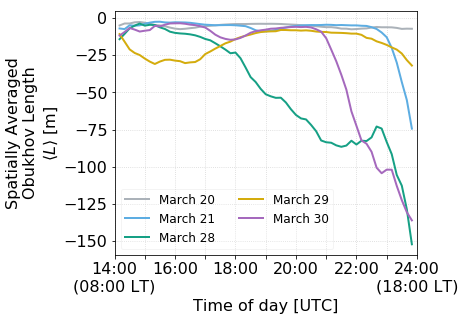

In [52]:
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111)

iday = 0
for day in days:
        
    series = l.loc["2015-03-{0}".format(day)]    
    deltas = series.index-series.index[0]+pd.Timedelta('14h')
    index  = start+deltas
    
    ax.plot(index[1:],
            series.values[1:],color=colors_days[day],linestyle='-',lw=2,
            marker='None',label='March {0}'.format(day))

xticks = index[0::6]
xticks = xticks.append(pd.DatetimeIndex([start+pd.Timedelta('24h')]))
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xticklabels(["14:00\n(08:00 LT)","","16:00","","18:00","","20:00","","22:00","","24:00\n(18:00 LT)"])
ax.set_xlim([xticks[0],xticks[-1]])
ax.set_xlabel("Time of day [UTC]")

ax.grid(color='lightgray',linestyle=':')

ax.set_ylabel("Spatially Averaged\nObukhov Length\n"+r"$\langle L \rangle$ [m]")

lg = plt.legend(ncol=2,fontsize=12,framealpha=0.2)
fig.subplots_adjust(left=0.2,bottom=0.2)

# # fig.savefig("/glade/u/home/doubrawa/figs/hfx_diurnal_cycles.png",dpi=300)

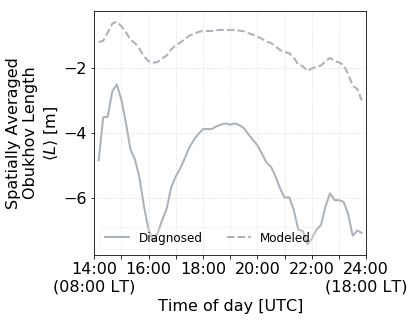

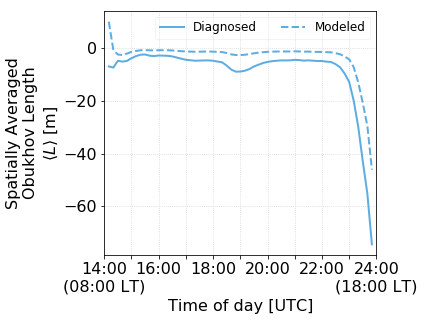

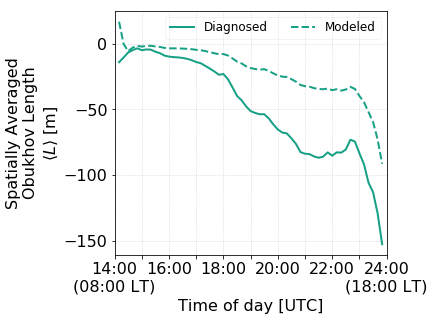

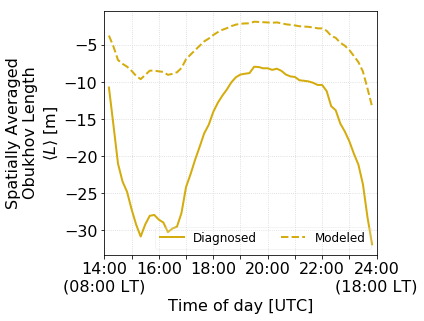

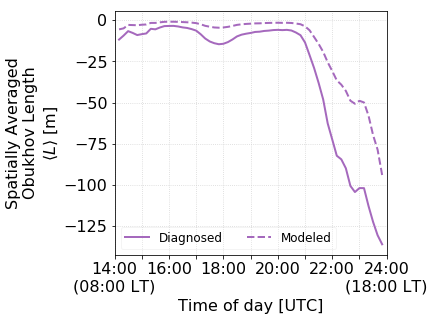

In [55]:
for day in days:
    
    fig = plt.figure(figsize=(6,5))
    ax  = fig.add_subplot(111)
   
    series = l.loc["2015-03-{0}".format(day)]    
    deltas = series.index-series.index[0]+pd.Timedelta('14h')
    index  = start+deltas
    
    ax.plot(index[1:],
            series.values[1:],color=colors_days[day],linestyle='-',lw=2,
            marker='None',label='Diagnosed')

    series = l_model.loc["2015-03-{0}".format(day)]    
    deltas = series.index-series.index[0]+pd.Timedelta('14h')
    index  = start+deltas
    
    ax.plot(index[1:],
            series.values[1:],color=colors_days[day],linestyle='--',lw=2,
            marker='None',label='Modeled')

    xticks = index[0::6]
    xticks = xticks.append(pd.DatetimeIndex([start+pd.Timedelta('24h')]))
    ax.set_xticks(xticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xticklabels(["14:00\n(08:00 LT)","","16:00","","18:00","","20:00","","22:00","","24:00\n(18:00 LT)"])
    ax.set_xlim([xticks[0],xticks[-1]])
    ax.set_xlabel("Time of day [UTC]")

    ax.grid(color='lightgray',linestyle=':')

    ax.set_ylabel("Spatially Averaged\nObukhov Length\n"+r"$\langle L \rangle$ [m]")

    lg = plt.legend(ncol=2,fontsize=12,framealpha=0.2)
    fig.subplots_adjust(left=0.25,bottom=0.2,right=0.88)
    
    fig.savefig(os.path.join(figPath,"L-comparison-ts-March{0}.png".format(day)),dpi=300)

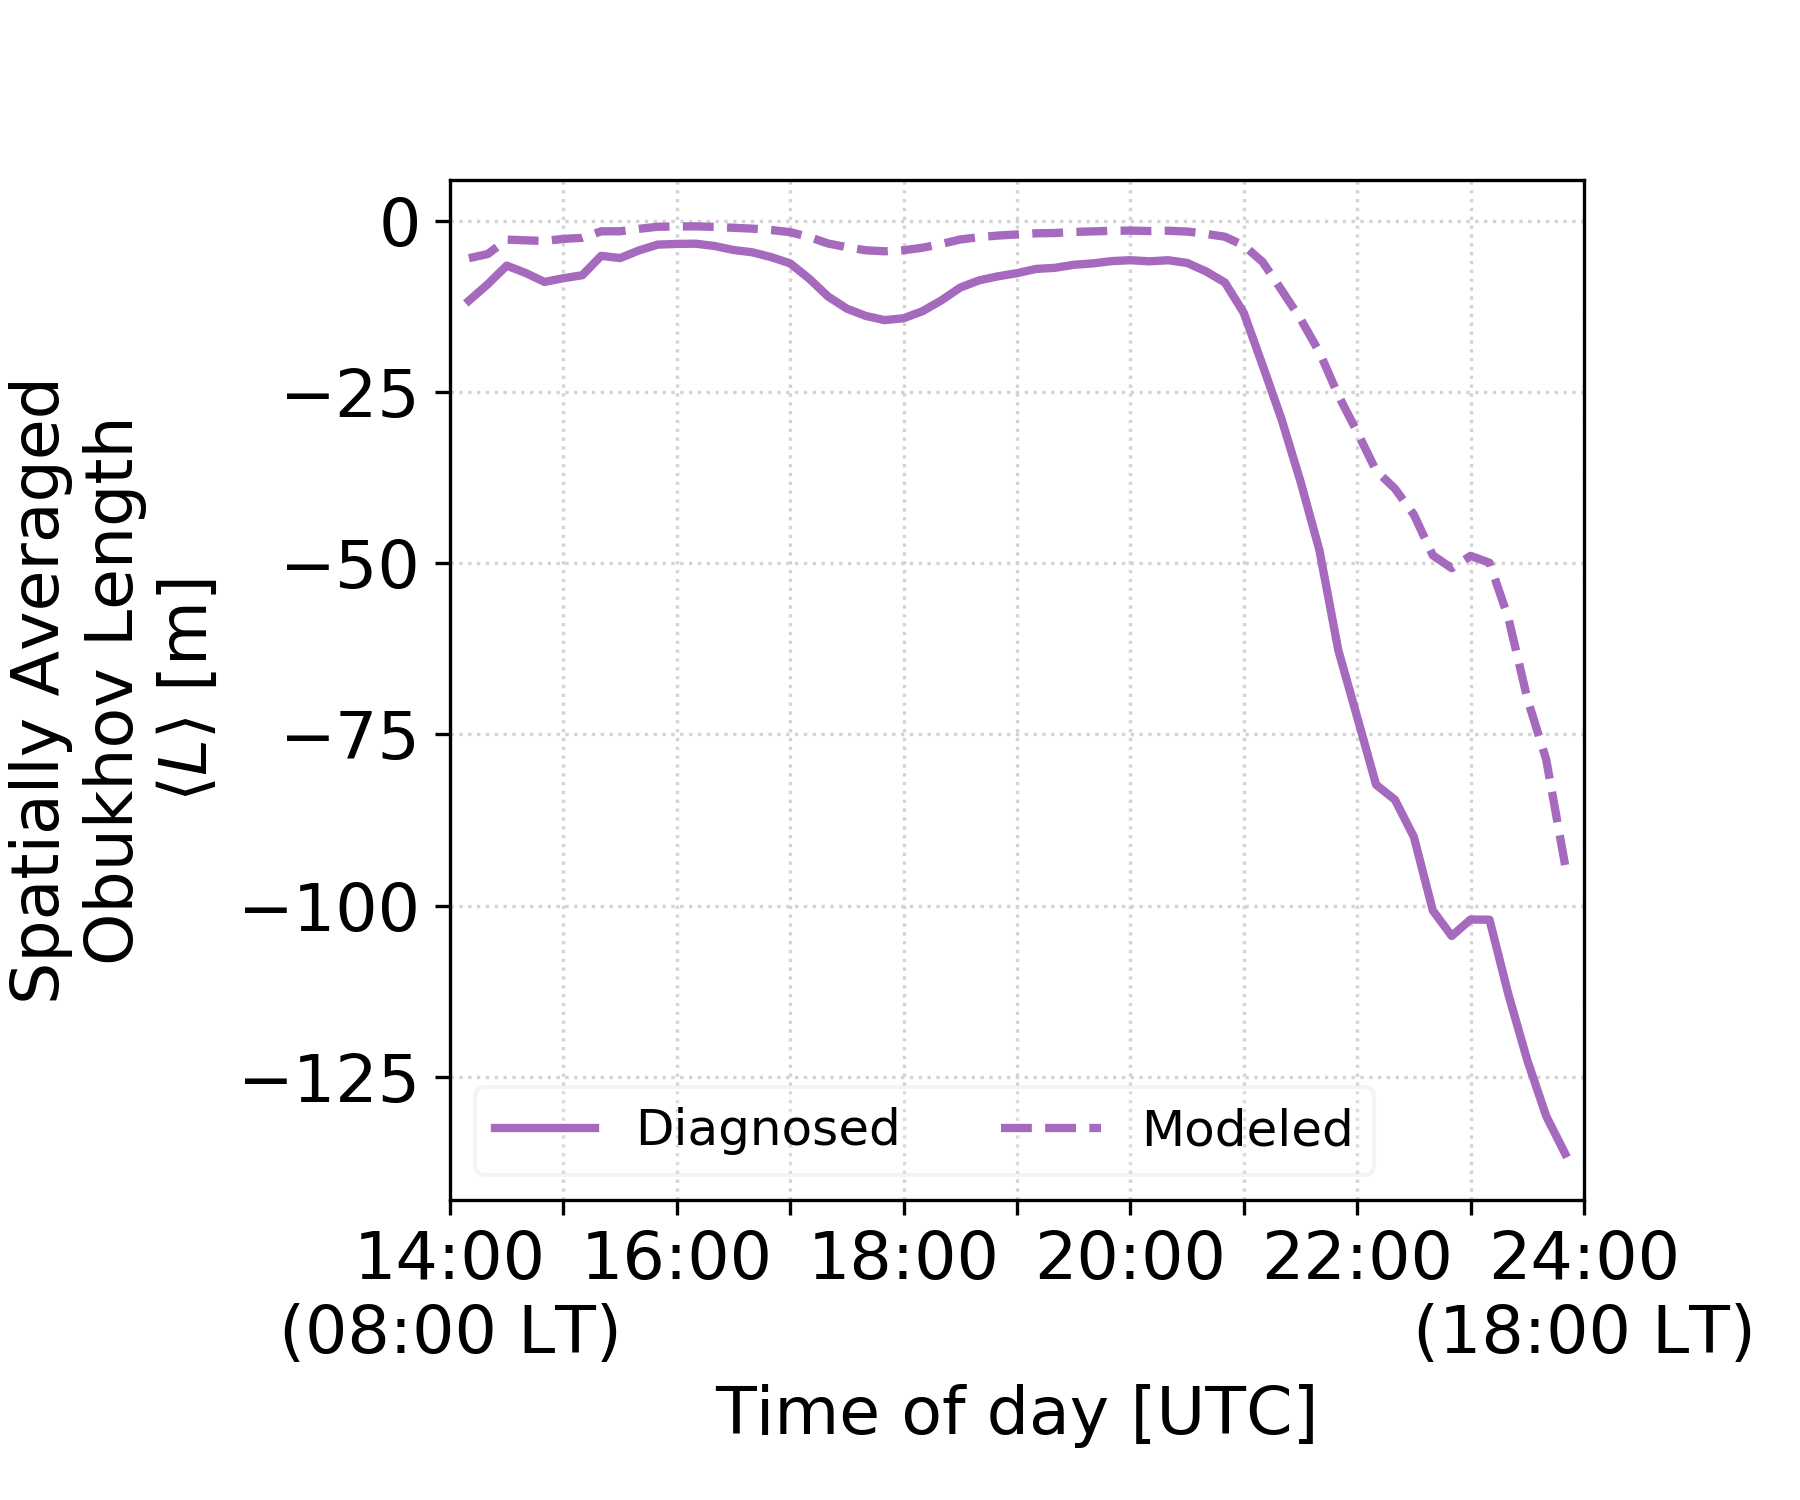

In [56]:
Image(os.path.join(figPath,"L-comparison-ts-March{0}.png".format(day)))